In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import datetime
import pandas_datareader as data

In [12]:
SPY_Firms = pd.read_csv('Firm_SPY500.csv', index_col = 'Symbol')
SPY_Firms.columns = (['Unnamed: 0', 'Firm', 'GICS Sector', 'Headquarters Location'])
SPY_Firms = SPY_Firms.sort_index()

In [13]:
#Create list of all Firm Symbol(Tickers) for looping purposes
Symbols = []
for symbol in SPY_Firms.index:
    Symbols.append(symbol)

In [15]:
#Import Data on each stock for last 30 days as dictionary
start = datetime.datetime(2021,10,11)
end = datetime.datetime(2021,11,22)
d = {}
for symbol in Symbols:
        try:
            d[symbol] = data.DataReader(symbol, 
                       start=start, 
                       end=end, 
                       data_source='yahoo')
        except KeyError:
            print('Further Analysis Required')

In [19]:
#Convert dictionary to DataFrame through concatination of dictionary values
Firms_SPY500_30 = pd.concat(d.values(),axis = 1, keys = Symbols)
Firms_SPY500_30.columns.names = ['Symbol', 'Info']
Firms_SPY500_30.to_pickle('Firms_SPY500_30.pkl')
Firms_SPY500_30.head(3)

Symbol               A                                               \
Info              High         Low        Open       Close   Volume   
Date                                                                  
2021-10-11  152.360001  149.880005  151.490005  150.020004  1106300   
2021-10-12  151.179993  146.300003  151.179993  147.949997  1809900   
2021-10-13  150.880005  148.740005  149.080002  150.220001  1509100   

Symbol                    AAL                                   ...  \
Info         Adj Close   High        Low       Open      Close  ...   
Date                                                            ...   
2021-10-11  150.020004  20.51  19.850000  19.980000  20.129999  ...   
2021-10-12  147.949997  20.40  20.030001  20.200001  20.290001  ...   
2021-10-13  150.220001  20.25  19.530001  20.250000  19.610001  ...   

Symbol           ZION                                        ZTS              \
Info             Open      Close   Volume  Adj Close        High         Low   
Date                                                                           
2021-10-11  64.080002  62.439999   800900  62.439999  199.100006  196.029999   
2021-10-12  62.180000  62.709999  1083000  62.709999  199.369995  195.770004   
2021-10-13  62.740002  62.139999   970600  62.139999  198.949997  195.789993   

Symbol                                                     
Info              Open       Close     Volume   Adj Close  
Date                                                       
2021-10-11  197.559998  197.649994   901900.0  197.414230  
2021-10-12  198.889999  197.149994  1398000.0  196.914825  
2021-10-13  196.970001  197.460007  1223800.0  197.224457  

[3 rows x 3030 columns]

In [20]:
#Show how no missing Data, speak a little about bias.

In [39]:
#DataFrame of solely the adjusted returns, talk about why adj vs close
Firms_SPY500_30_Adj = Firms_SPY500_30.xs(key = 'Adj Close', axis = 1, level='Info')
Firms_SPY500_30_Adj.head(1)

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-11,150.020004,20.129999,212.119995,142.601883,109.018311,121.952042,332.149994,116.430458,325.533539,573.070007,...,62.439999,155.199997,60.743652,57.169998,118.532364,121.518127,143.789993,493.130005,62.439999,197.41423


In [50]:
#Create DataFrame of Daily Returns for each stock
Daily_Return = pd.DataFrame()
for symbol in Symbols:
    Daily_Return[symbol] = Firms_SPY500_30_Adj[symbol].pct_change()
Daily_Return.drop(labels = start, axis = 0, inplace = True)
Daily_Return.isna().values.any()

False

In [51]:
#Create DataFrame for the cumulative returns of each stock
Daily_Return_Cum = (Daily_Return+1).cumprod() - 1
Daily_Return_Cum.tail(1)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-22,0.085055,-0.024839,0.092919,0.129158,0.060831,-0.006823,0.009544,0.075835,0.116014,0.175371,...,0.061979,0.420941,0.012616,-0.084135,0.076584,0.036639,-0.094374,0.22274,0.061019,0.136392


In [ ]:
#Create DataFrame of 30 day cumulative Return with firm info
Returns_30day = pd.DataFrame(Daily_Return_Cum.iloc[-1])
Returns_30day.columns = ['30d Return']
Returns_30day.index.names = [('Symbol')]
Returns_30day_info = pd.DataFrame(SPY_Firms.merge(Returns_30day, on = 'Symbol'))
Returns_30day_info.drop(columns = ['Unnamed: 0', 'Headquarters Location'], inplace = True)
Returns_30day_info.sort_values('Symbol') 

<AxesSubplot:>

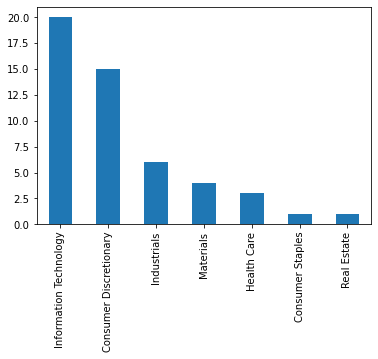

In [74]:
#What sector do the top perfomring stock belong to 
###Insight 1, part 1. Note 2 sectors dominates
Top_Firms = Returns_30day_info.sort_values('30d Return', ascending = False).head(50)
Top_Firms['GICS Sector'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

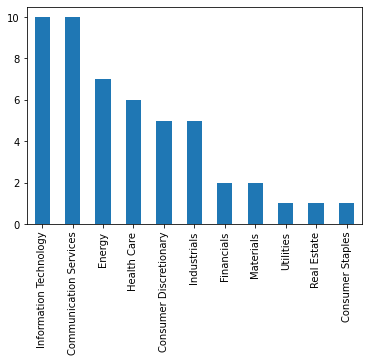

In [75]:
#Bottom 10 Performing Stocks
###Insight 1, part 2.Indeed presence of IT again says something which should prompt overall analysis of sectorsBo
Bottom_Firms = Returns_30day_info.sort_values('30d Return', ascending = True).head(50)
Bottom_Firms['GICS Sector'].value_counts().plot(kind = 'bar')

Industrials               74
Information Technology    74
Financials                65
Health Care               64
Consumer Discretionary    63
Consumer Staples          32
Real Estate               29
Utilities                 28
Materials                 28
Communication Services    27
Energy                    21
Name: GICS Sector, dtype: int64

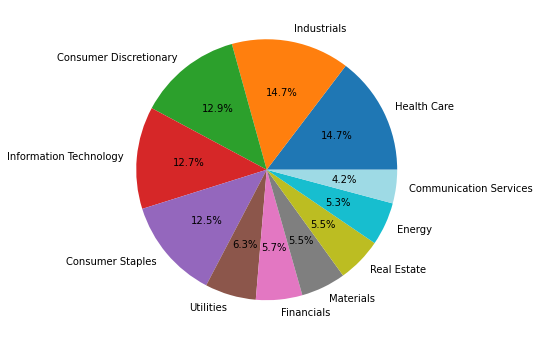

In [97]:
#Check for over  representation
fig = plt.figure(figsize = (6,6))
Returns_30day_info['GICS Sector'].value_counts().plot(kind = 'pie', labels = Returns_30day_info['GICS Sector'].unique(), autopct='%1.1f%%', colormap = 'tab20')
plt.ylabel('')
Returns_30day_info['GICS Sector'].value_counts()

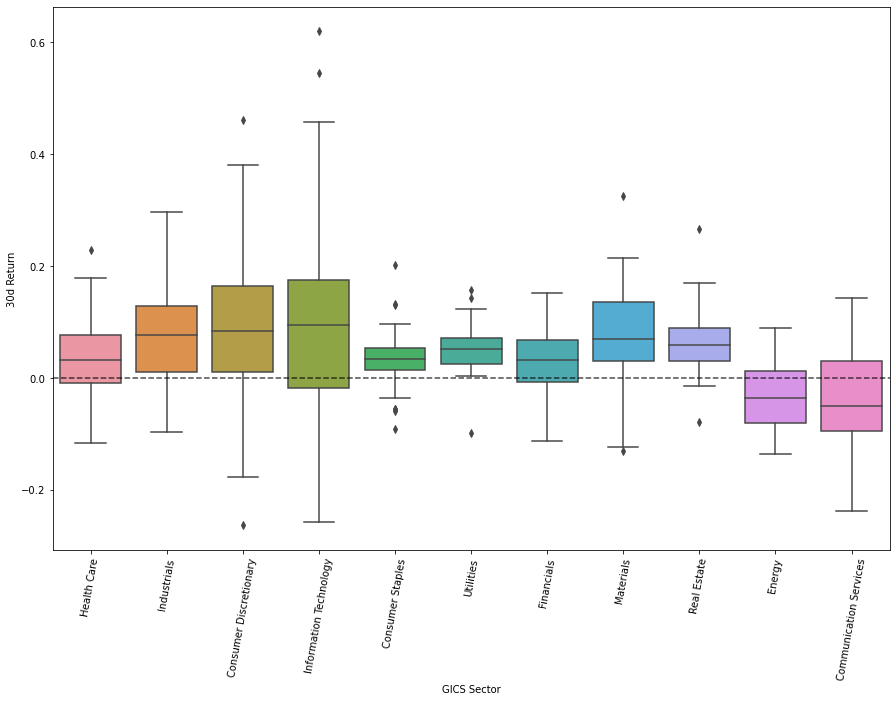

In [107]:
#Insight 2. Measure of skewness and distribution, we can see IT is very spread out vs utilites compact.
fig = plt.figure(figsize = (15,10))
a = sns.boxplot(x = Returns_30day_info['GICS Sector'], y = Returns_30day_info['30d Return'],data = Returns_30day_info, showfliers = True)
a.set_xticklabels(a.get_xticklabels(),rotation=80)
plt.axhline(y=0 ,c = 'black', alpha = .7, ls = '--')
plt.show(a)
#Include overall median performance line

In [118]:
#Repeat for standard Deviation. include top ten, bottom 10 and then boxplot
SPY_Firms_30d_STD = pd.DataFrame(Firms_SPY500_30_Adj.std())
SPY_Firms_30d_STD.columns = ['30d Standard Deviation']
SPY_Firms_30d_STD = SPY_Firms.merge(SPY_Firms_30d_STD, on = 'Symbol')
SPY_Firms_30d_STD.drop(columns = ['Unnamed: 0', 'Headquarters Location'], inplace = True)
SPY_Firms_30d_STD = SPY_Firms_30d_STD.set_index('Symbol').sort_values('Symbol')

<AxesSubplot:>

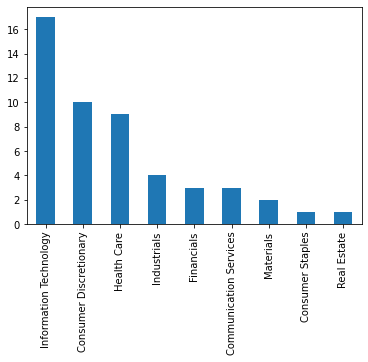

In [126]:
#Top 10 volatile stock
Most_vol = (SPY_Firms_30d_STD.sort_values('30d Standard Deviation', ascending = False)).head(50)
Most_vol['GICS Sector'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

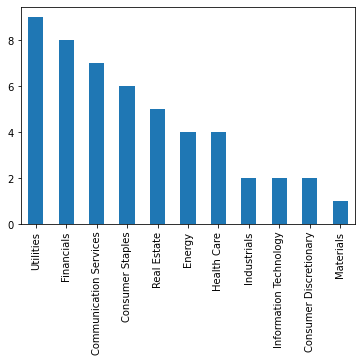

In [127]:
Least_Vol = (SPY_Firms_30d_STD.sort_values('30d Standard Deviation', ascending = True)).head(50)
Least_Vol['GICS Sector'].value_counts().plot(kind = 'bar')

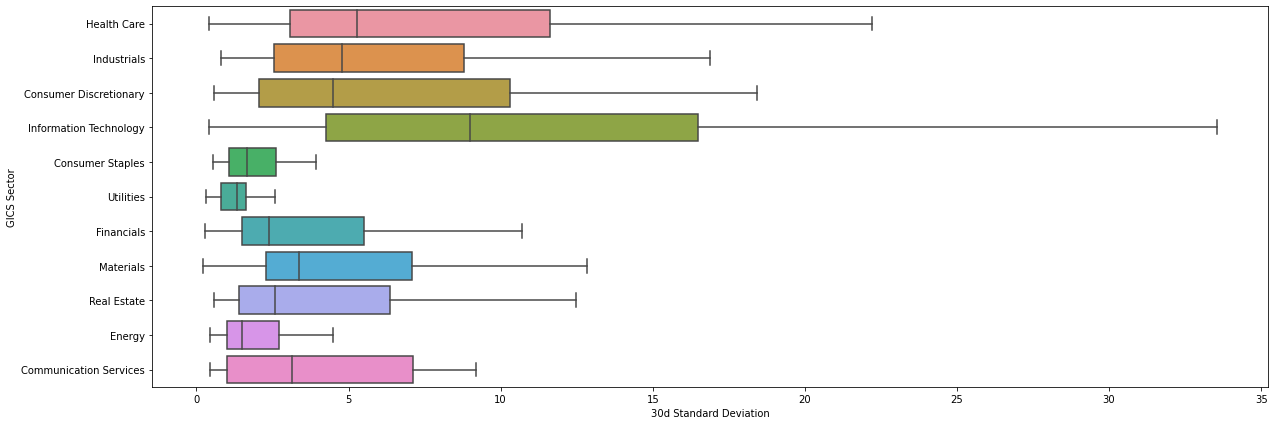

In [207]:
#std by sector, remember we're not looking for mean std of sector rather looking at how std's are spread out
#ignore outliers and hope for the best
fig = plt.figure(figsize = (20,7))
b = sns.boxplot(y = SPY_Firms_30d_STD['GICS Sector'], x = '30d Standard Deviation', data = SPY_Firms_30d_STD, showfliers = False)
b.set_yticklabels(b.get_yticklabels(),rotation=0)
plt.show(b)

In [208]:
Firm_corr_abs= pd.DataFrame(Daily_Return.corr().abs().unstack().sort_values(ascending = False)[505::2])
Firm_corr_abs.columns = ['Correlation Coefficient']
Firm_corr_abs.index.names = ['Symbol 1','Symbol 2']

In [320]:
Firm_corr = pd.DataFrame(Daily_Return.corr().unstack())
Firm_corr.columns = ['Correlation Coefficient']
Firm_corr.index.names = ['Symbol 1','Symbol 2']
m = pd.DataFrame(Firm_corr.merge(Firm_corr_abs, on = ['Symbol 1','Symbol 2'])['Correlation Coefficient_x'])
m.reset_index(inplace = True)
m = m

m.set_index('Symbol 1', inplace= True)
m['Symbol 1 Sector'] = 0
m['Symbol 2 Sector'] = 0
for each in m.index:
    m.loc[each, 'Symbol 2 Sector'] = SPY_Firms.loc[each]['GICS Sector']
    
m.reset_index(inplace = True)

m.set_index('Symbol 2', inplace= True)
for each in m.index:
    m.loc[each, 'Symbol 1 Sector'] = SPY_Firms.loc[each]['GICS Sector']
    
m.reset_index(inplace = True)
m.set_index('Symbol 1', inplace= True)
m.reset_index(inplace = True)

m.to_csv('Stock_Corr_wSec')

In [331]:
m = m.sort_values(by = 'Correlation Coefficient_x', ascending = True)
m['Sector Same'] = m['Symbol 1 Sector'] == m['Symbol 2 Sector']
m[m['Sector Same']]

,Symbol 1,Symbol 2,Correlation Coefficient_x,Symbol 1 Sector,Symbol 2 Sector,Sector Same
65049,JNPR,JKHY,-0.654836,Information Technology,Information Technology,True
69148,LEG,UAA,-0.641713,Consumer Discretionary,Consumer Discretionary,True
69147,LEG,UA,-0.637317,Consumer Discretionary,Consumer Discretionary,True
116611,UPS,LMT,-0.615564,Industrials,Industrials,True
47162,FISV,JNPR,-0.608203,Information Technology,Information Technology,True
...,...,...,...,...,...,...
48373,FOXA,FOX,0.983750,Communication Services,Communication Services,True
114692,UA,UAA,0.990303,Consumer Discretionary,Consumer Discretionary,True
81212,MTB,PBCT,0.991505,Financials,Financials,True
51666,GOOG,GOOGL,0.993857,Communication Services,Communication Services,True
